In [ ]:
import pandas as pd
import numpy as np
import nltk
import spacy
from sklearn.preprocessing import OneHotEncoder

In [ ]:
df = pd.read_csv("Restaurants_Train_v2.csv")
df.head()


,id,Sentence,Aspect Term,polarity,from,to
0,3121,But the staff was so horrible to us.,staff,negative,8,13
1,2777,"To be completely fair, the only redeeming fact...",food,positive,57,61
2,1634,"The food is uniformly exceptional, with a very...",food,positive,4,8
3,1634,"The food is uniformly exceptional, with a very...",kitchen,positive,55,62
4,1634,"The food is uniformly exceptional, with a very...",menu,neutral,141,145


### Removing id column , from,to columns 

In [ ]:
df = df.drop('id',axis=1)
df = df.drop('from',axis=1)
df = df.drop('to',axis=1)

df

,Sentence,Aspect Term,polarity
0,But the staff was so horrible to us.,staff,negative
1,"To be completely fair, the only redeeming fact...",food,positive
2,"The food is uniformly exceptional, with a very...",food,positive
3,"The food is uniformly exceptional, with a very...",kitchen,positive
4,"The food is uniformly exceptional, with a very...",menu,neutral
...,...,...,...
3688,Each table has a pot of boiling water sunken i...,pot of boiling water,neutral
3689,Each table has a pot of boiling water sunken i...,meats,neutral
3690,Each table has a pot of boiling water sunken i...,vegetables,neutral
3691,Each table has a pot of boiling water sunken i...,rice,neutral


#### changing polarity to numbers , negative=-1, positive=1 , neutral=0

In [ ]:
def map_to_int(x):
    if x=='positive':
        return 1
    elif x=='negative':
        return -1
    else:
        return 0
df['polarity'] = df['polarity'].apply(map_to_int)
df

,Sentence,Aspect Term,polarity
0,But the staff was so horrible to us.,staff,-1
1,"To be completely fair, the only redeeming fact...",food,1
2,"The food is uniformly exceptional, with a very...",food,1
3,"The food is uniformly exceptional, with a very...",kitchen,1
4,"The food is uniformly exceptional, with a very...",menu,0
...,...,...,...
3688,Each table has a pot of boiling water sunken i...,pot of boiling water,0
3689,Each table has a pot of boiling water sunken i...,meats,0
3690,Each table has a pot of boiling water sunken i...,vegetables,0
3691,Each table has a pot of boiling water sunken i...,rice,0


## Idea how to take input :
#### step1: convert the input setence into token of words with each token as 768 dimension vector from which we get from BERT embedding
#### step2: Append the upos(universal parts of speech) of each word to above vector 
#### step3: Append also xpos(extended parts of speech) of each word to above appended vector

#### For step2: Converting a word into one-hot encoded upos vector using 'ntlk' library and it outputs with dimension value of 37. (Alternatively, if we use spacy library it will give with 17dimension)

In [ ]:
#downlaod the required data
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ubuntu/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /home/ubuntu/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

Upos tagging for single word

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/ubuntu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
def splitSentence(sentence):
    split_sentence = sentence.split(",") # split by commas
    split_sentence = [word.split() for word in split_sentence] # split each word by space
    split_sentence = [word for sublist in split_sentence for word in sublist] # flatten the list of lists

    return split_sentence

In [ ]:
# Create a one-hot encoder and fit it to the set of UPOS tags
#this below tags are used by nltk for giving pos_tags.
upos_tags = ['CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS',
             'MD', 'NN', 'NNS', 'NNP', 'NNPS', 'PDT', 'POS', 'PRP', 'PRP$',
             'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG',
             'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB','PUNCT']
encoder = OneHotEncoder(sparse=False, categories=[upos_tags])
encoder.fit(np.array(upos_tags).reshape(-1, 1)) #fit
def upos_tagging_word(word):

    # Use the NLTK tagger to tag the word and extract the UPOS tag
    upos = nltk.pos_tag([word]) # example this will be [('author','NN')]
    # print("upos=", upos)
    upos_tag = upos[0][1] #"NN"
    if upos_tag==',' or upos_tag=='.' or upos_tag=='?':
        upos_tag = 'PUNCT'
    # print("upos_tag=",upos_tag)
    if upos_tag not in upos_tags:
        vector = np.zeros((1,37))
        return vector
#     if upos_tag is not in upos_tags:
        
    # np.array([upos_tag]).reshape(-1, 1)) converts to [['NN']]
    # Transform the UPOS tag into a one-hot encoded vector
    onehot_vector = encoder.transform(np.array([upos_tag]).reshape(-1, 1))
    return onehot_vector

Upos tagging for sentence

In [ ]:
def upos_tagging(sentence):
    answer = []
    tokens = splitSentence(sentence)
    for i in tokens:
        word_tag = upos_tagging_word(i)
        answer.append(torch.tensor(word_tag[0]))
    return answer

Example output for tagging sentence "the author": <br>
upos= [('the', 'DT')] <br>
upos_tag= DT <br>
upos= [('author', 'NN')]<br>
matrix for sentence after converting to upos vectors = [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

#### For step2: Converting a word into one-hot encoded upos vector using 'ntlk' library and it outputs with dimension value of 37. (Alternatively, if we use spacy library it will give with 17dimension)

In [ ]:
#!python3 -m spacy download en_core_web_sm



In [ ]:
# load the English language model
nlp = spacy.load('en_core_web_sm')
top_17_xpos = ['NN', 'IN', 'PRP', 'DT', 'JJ', 'VB', 'RB', 'NNS', 'VBP', 'VBZ', 'VBN', 'VBG', 'CD', 'CC', 'TO', 'MD', 'POS']

In [ ]:
# def xpos_tagging(sentence):
#     doc = nlp(sentence)
#     one_hot_vectors = []           # initialize an empty list to store the one-hot encoded vectors for each word

    
#     for token in doc:              # iterate over each token in the Doc object
        
#         xpos_list = token.tag_
#         one_hot_vector = [int(xpos in xpos_list) for xpos in top_17_xpos]   # create a one-hot encoded vector for the token's XPOS tags
#         one_hot_vectors.append(one_hot_vector)                              # add the one-hot encoded vector to the list

#     # print the list of one-hot encoded vectors
#     print(np.array(one_hot_vectors))
import numpy as np

top_17_xpos = ['NN', 'IN', 'PRP', 'DT', 'JJ', 'VB', 'RB', 'NNS', 'VBP', 'VBZ', 'VBN', 'VBG', 'CD', 'CC', 'TO', 'MD', 'POS']

def xpos_tagging(sentence):
    tokens = splitSentence(sentence)             # split the sentence into individual words
    one_hot_vectors = []                  # initialize an empty list to store the one-hot encoded vectors for each word

    for token in tokens:       
#         print(nlp(token))           # iterate over each token in the sentence
        xpos_list = (nlp(token)[0]).tag_  # get the XPOS tags for the token
        one_hot_vector = [int(xpos in xpos_list) for xpos in top_17_xpos]   # create a one-hot encoded vector for the token's XPOS tags
        one_hot_vectors.append(torch.tensor(one_hot_vector) )  # add the one-hot encoded vector to the list

    # print the list of one-hot encoded vectors
    return one_hot_vectors


### Need Compare the performance of a model by taking only word2vec vector , after adding upos, after adding xpos

### ASPECT EXTRACTION USING BERT 

In [ ]:
df

,Sentence,Aspect Term,polarity
0,But the staff was so horrible to us.,staff,-1
1,"To be completely fair, the only redeeming fact...",food,1
2,"The food is uniformly exceptional, with a very...",food,1
3,"The food is uniformly exceptional, with a very...",kitchen,1
4,"The food is uniformly exceptional, with a very...",menu,0
...,...,...,...
3688,Each table has a pot of boiling water sunken i...,pot of boiling water,0
3689,Each table has a pot of boiling water sunken i...,meats,0
3690,Each table has a pot of boiling water sunken i...,vegetables,0
3691,Each table has a pot of boiling water sunken i...,rice,0


In [ ]:
# !pip install transformers
# !pip install torch

In [ ]:
import pandas as pd
import numpy as np
import torch
import transformers
from transformers import BertTokenizer, BertForTokenClassification, BertForSequenceClassification , BertModel
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


### Preprosesing dataset 

In [ ]:
df

,Sentence,Aspect Term,polarity
0,But the staff was so horrible to us.,staff,-1
1,"To be completely fair, the only redeeming fact...",food,1
2,"The food is uniformly exceptional, with a very...",food,1
3,"The food is uniformly exceptional, with a very...",kitchen,1
4,"The food is uniformly exceptional, with a very...",menu,0
...,...,...,...
3688,Each table has a pot of boiling water sunken i...,pot of boiling water,0
3689,Each table has a pot of boiling water sunken i...,meats,0
3690,Each table has a pot of boiling water sunken i...,vegetables,0
3691,Each table has a pot of boiling water sunken i...,rice,0


### combining all aspect terms together for a unique sentences

In [ ]:
df1 = df_grouped = df.groupby('Sentence').agg({'Aspect Term': lambda x: x.tolist(), 'polarity': lambda x: x.tolist()}).reset_index()


In [ ]:
df1

,Sentence,Aspect Term,polarity
0,"$160 for 2 filets, 2 sides, an appetizer and d...","[filets, sides, appetizer, drinks]","[0, 0, 0, 0]"
1,$20 for all you can eat sushi cannot be beaten.,[sushi],[0]
2,$20 gets you unlimited sushi of a very high qu...,"[sushi, sushi places, quality]","[1, 1, 1]"
3,"$6 and there is much tasty food, all of it fre...",[food],[1]
4,"($200 for 2 glasses of champagne, not too expe...","[glasses of champagne, bottle of wine, after d...","[-1, -1, -1]"
...,...,...,...
2014,we were tired and cold when we got to the rest...,[appetizers],[0]
2015,"word of advice, save room for pasta dishes and...","[pasta dishes, tiramisu]","[1, 1]"
2016,would have rather tried terrace in the sky or ...,[price],[-1]
2017,you can actually get 2 salads worth if u take ...,"[salads, lettuce]","[-1, 0]"


### converting each sentence to tokens and labelling each token to {B,I,O} 

In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_with_whitespace(text):         ##split the sentence by whitespaces
    """
    Tokenize text using whitespace as a delimiter
    """
    tokens = splitSentence(text)
    return tokens

def get_token_offsets(text):               ## tokens and their offsets. example: "the rice is good", here this function returns ['the','rice','is','good'],[(1,3),(5,8),(10,11),(13,16)]
    tokens = []
    offsets = []
    for token in tokenize_with_whitespace(text):
        tokens.append(token)
        start_index = text.find(token)
        end_index = start_index + len(token)
        offsets.append((start_index, end_index))
    return tokens, offsets

def get_token_spans(offsets):
    spans = [(offsets[i][0], offsets[i+1][0] if i < len(offsets) - 1 else offsets[i][1]) for i in range(len(offsets))]
    return spans

def convert_to_b_i_o(sentence, aspect_terms):             ##this converts the each token in sentence to {'I','O','B'}
    # Get corresponding token offsets and spans for sentence
    tokens, offsets = get_token_offsets(sentence)
    spans = get_token_spans(offsets)
    
    tags = ["O"] * len(tokens)                              # Convert sentence to B-I-O tags
    for aspect_term in aspect_terms:
        aspect_words = tokenize_with_whitespace(aspect_term)
        aspect_words_len = len(aspect_words)
        
        start_index = None                                  # Find the start and end indexes of the aspect term within the sentence
        end_index = None
        for i in range(len(tokens) - aspect_words_len + 1):
            if tokens[i:i+aspect_words_len] == aspect_words:
                start_index = i
                end_index = i + aspect_words_len
                break
                
        if start_index is not None and end_index is not None:
            # Find the start and end offsets of the aspect term within the sentence
            start_offset = spans[start_index][0]
            end_offset = spans[end_index-1][1]
            
            # Update tags list with B-I-O tags for aspect term
            for i in range(start_index, end_index):
                if i == start_index:
                    tags[i] = "B"
                else:
                    tags[i] = "I"
    
    return tags


In [ ]:
df1

,Sentence,Aspect Term,polarity
0,"$160 for 2 filets, 2 sides, an appetizer and d...","[filets, sides, appetizer, drinks]","[0, 0, 0, 0]"
1,$20 for all you can eat sushi cannot be beaten.,[sushi],[0]
2,$20 gets you unlimited sushi of a very high qu...,"[sushi, sushi places, quality]","[1, 1, 1]"
3,"$6 and there is much tasty food, all of it fre...",[food],[1]
4,"($200 for 2 glasses of champagne, not too expe...","[glasses of champagne, bottle of wine, after d...","[-1, -1, -1]"
...,...,...,...
2014,we were tired and cold when we got to the rest...,[appetizers],[0]
2015,"word of advice, save room for pasta dishes and...","[pasta dishes, tiramisu]","[1, 1]"
2016,would have rather tried terrace in the sky or ...,[price],[-1]
2017,you can actually get 2 salads worth if u take ...,"[salads, lettuce]","[-1, 0]"


In [ ]:
df1['labels'] = 1

In [ ]:
for i in range(0,len(df1['Sentence'])):
    a = convert_to_b_i_o(df1['Sentence'][i], df1['Aspect Term'][i])
    df1['labels'][i] = a

<ipython-input-93-1c2444cb4cb9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['labels'][i] = a
/home/ubuntu/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [ ]:
df1

,Sentence,Aspect Term,polarity,labels
0,"$160 for 2 filets, 2 sides, an appetizer and d...","[filets, sides, appetizer, drinks]","[0, 0, 0, 0]","[O, O, O, B, O, B, O, B, O, O]"
1,$20 for all you can eat sushi cannot be beaten.,[sushi],[0],"[O, O, O, O, O, O, B, O, O, O]"
2,$20 gets you unlimited sushi of a very high qu...,"[sushi, sushi places, quality]","[1, 1, 1]","[O, O, O, O, B, O, O, O, O, O, O, O, O, O, O, ..."
3,"$6 and there is much tasty food, all of it fre...",[food],[1],"[O, O, O, O, O, O, B, O, O, O, O, O, O, O]"
4,"($200 for 2 glasses of champagne, not too expe...","[glasses of champagne, bottle of wine, after d...","[-1, -1, -1]","[O, O, O, B, I, I, O, O, O, B, I, I, O, O, O, ..."
...,...,...,...,...
2014,we were tired and cold when we got to the rest...,[appetizers],[0],"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
2015,"word of advice, save room for pasta dishes and...","[pasta dishes, tiramisu]","[1, 1]","[O, O, O, O, O, O, B, I, O, O, O, O, O, O, O, O]"
2016,would have rather tried terrace in the sky or ...,[price],[-1],"[O, O, O, O, O, O, O, O, O, O, O, O, O, B]"
2017,you can actually get 2 salads worth if u take ...,"[salads, lettuce]","[-1, 0]","[O, O, O, O, O, B, O, O, O, O, O, O, O, O, O, ..."


In [ ]:
## converting sentence into tokens of vectors. each vector is of 768 dimension
model = BertModel.from_pretrained('bert-base-uncased')

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased') 
def bert_to_token(sentence):
   

  # Define the sentence to be tokenized

  # Tokenize the sentence
  tokens = splitSentence(sentence)
  # print(len(tokens))
  # Convert tokens to ids
  input_ids = tokenizer.convert_tokens_to_ids(tokens)
  # print(len(input_ids))
  # Add special tokens
  # Convert input_ids to tensor
  input_ids = torch.tensor(input_ids).unsqueeze(0)
  # print(len(input_ids))
  # Get the 768 dimensional vectors for each token
  outputs = model(input_ids)
  # print(outputs,len(outputs))
  token_vectors = outputs.last_hidden_state.squeeze(0)
  return token_vectors

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
label_map = {'O':0,'B':1,'I':2}
labels = []
for label_list in df1['labels']:
    
    # Convert labels to tensor
    label_tensor = torch.tensor([label_map[label] for label in label_list], dtype=torch.long)
    labels.append(list(label_tensor))

### Analysing classes imbalance issue


In [ ]:
C_0 = 0
C_1 = 1
C_2 = 2
for label in labels:
    for i in label:
        if i==0:
            C_0 = C_0 + 1
        if i==1:
            C_1 = C_1 + 1
        if i==2:
            C_2 = C_2 + 1
            
class_counts = [C_0, C_1, C_2] 
class_weights = torch.tensor([1.0, sum(class_counts) / (2 * class_counts[1]), sum(class_counts) / (2 * class_counts[2])])

**BERT+CLASSIFICATION**



In [ ]:
class_weights = torch.tensor([1.00,4.00,14.00])

appending tokens of vectors of all sentences

In [ ]:
import logging
logging.getLogger("transformers.modeling_utils").setLevel(logging.ERROR)
Bert_toks = []
for i in range(2019):
  t = bert_to_token(df1['Sentence'][i])
  Bert_toks.append(t)

Training the model

In [ ]:
import logging
logging.getLogger("transformers.modeling_utils").setLevel(logging.ERROR)
classification_layer = torch.nn.Linear(768, 3)

# Define the optimizer and loss function
optimizer = torch.optim.Adam(classification_layer.parameters(), lr=1e-5)
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)

for epoch in range(15):
    for j in range(1500):
        token_vectors = Bert_toks[j]
        # Run token vectors through classification layer
        logits = classification_layer(token_vectors)
        
        # Compute loss and perform backpropagation
        loss = loss_fn(logits, torch.tensor(labels[j]))
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
    print('Epoch:', epoch, 'Loss:', loss.item())
torch.save(classification_layer.state_dict(), 'classification_layer_weights1.pth')

Epoch: 0 Loss: 0.8845844268798828
Epoch: 1 Loss: 0.7992461919784546
Epoch: 2 Loss: 0.7408242225646973
Epoch: 3 Loss: 0.6952664852142334
Epoch: 4 Loss: 0.656871497631073
Epoch: 5 Loss: 0.6233540177345276
Epoch: 6 Loss: 0.5935853123664856
Epoch: 7 Loss: 0.5668711066246033
Epoch: 8 Loss: 0.542718231678009
Epoch: 9 Loss: 0.520750880241394
Epoch: 10 Loss: 0.5006709694862366
Epoch: 11 Loss: 0.4822370409965515
Epoch: 12 Loss: 0.46525105834007263
Epoch: 13 Loss: 0.44954797625541687
Epoch: 14 Loss: 0.43498918414115906


*Prediction*

In [ ]:
import torch
# Define the model architecture
def predict_normal(predict_sentence):
    classification_layer = torch.nn.Linear(768, 3)

    # Load the saved weights
    classification_layer.load_state_dict(torch.load('classification_layer_weights1.pth'))

    # Set the model to evaluation mode
    classification_layer.eval()

    # Obtain token vectors for the new input data
    token_vectors = bert_to_token(predict_sentence)

    # Feed the token vectors through the classification layer to obtain logits
    logits = classification_layer(token_vectors)
    
    # Convert the logits to probabilities using softmax
    probabilities = torch.nn.functional.softmax(logits, dim=1)
#     print(probabilities)
    # Get the predicted class index
    predicted_class_index = torch.argmax(probabilities, dim=1)
    
    return predicted_class_index

predict_normal("the chicken wings are good, but the kitchen is bad")

tensor([[0.5475, 0.3268, 0.1257],
        [0.2232, 0.5053, 0.2715],
        [0.2387, 0.2939, 0.4673],
        [0.6927, 0.1025, 0.2048],
        [0.5932, 0.2058, 0.2010],
        [0.6594, 0.1686, 0.1720],
        [0.6588, 0.1756, 0.1656],
        [0.0995, 0.7191, 0.1814],
        [0.8507, 0.0600, 0.0893],
        [0.6872, 0.1995, 0.1133]], grad_fn=<SoftmaxBackward0>)


tensor([0, 1, 2, 0, 0, 0, 0, 1, 0, 0])

In [ ]:
def aspect_term_detect(sentence):
    split = splitSentence(sentence)
    ans = predict_normal(sentence)
    aspect_terms = []
    aspect_term = ""
    n = len(ans)
    i = 0
    while i<n:
        if ans[i]==1:
            aspect_term = split[i]
            i = i + 1
            while i<n and ans[i]==2:
                aspect_term = aspect_term + " " + split[i]
                i = i + 1
            aspect_terms.append(aspect_term)
        else:
            i = i + 1
    return aspect_terms
s = "the chicken wings are good, but the kitchen is bad"
print(aspect_term_detect(s))
            

tensor([[0.5475, 0.3268, 0.1257],
        [0.2232, 0.5053, 0.2715],
        [0.2387, 0.2939, 0.4673],
        [0.6927, 0.1025, 0.2048],
        [0.5932, 0.2058, 0.2010],
        [0.6594, 0.1686, 0.1720],
        [0.6588, 0.1756, 0.1656],
        [0.0995, 0.7191, 0.1814],
        [0.8507, 0.0600, 0.0893],
        [0.6872, 0.1995, 0.1133]], grad_fn=<SoftmaxBackward0>)
['chicken wings', 'kitchen']


Accuracy:

In [ ]:
count = 0
correct = 0
for i in range(1500,2019):
    predict = predict_normal(df1['Sentence'][i])
    actual = labels[i]
    for j in range(len(actual)):
        if actual[j]==predict[j]:
            correct = correct+1
            count = count + 1
        else:
            count = count + 1
print("Accuracy=",correct*100/count,"%")

Accuracy= 87.88022488389147 %


**BERT + upos**

*Adding BERT output values to upos for all tokens and all sentences*

In [ ]:
upos = []
for i in range(len(df1['Sentence'])):
    a1 = bert_to_token(df1['Sentence'][i])
    a = upos_tagging(df1['Sentence'][i])
    b=torch.stack(a)
    concatenated_tensor = torch.cat((a1, b), dim=1)
    upos.append(concatenated_tensor)

In [ ]:
classification_layer1 = torch.nn.Linear(805, 3)

# Define the optimizer and loss function
optimizer1 = torch.optim.Adam(classification_layer1.parameters(), lr=1e-5)
loss_fn1 = torch.nn.CrossEntropyLoss(weight=class_weights)

for epoch in range(15):
    for j in range(1500):
        token_vectors = upos[j]
        token_vectors = token_vectors.to(classification_layer1.weight.dtype)
        # Run token vectors through classification layer
        logits = classification_layer1(token_vectors)
        
        # Compute loss and perform backpropagation
        loss1 = loss_fn1(logits, torch.tensor(labels[j]))
        optimizer1.zero_grad()
        loss1.backward(retain_graph=True)
        optimizer1.step()
    print('Epoch:', epoch, 'Loss:', loss1.item())
torch.save(classification_layer1.state_dict(), 'classification_layer_weights2.pth')

In [ ]:
import torch
# Define the model architecture
def predict_upos(predict_sentence):
    classification_layer1 = torch.nn.Linear(805, 3)
    # Load the saved weights
    classification_layer1.load_state_dict(torch.load('classification_layer_weights2.pth'))

    # Set the model to evaluation mode
    classification_layer1.eval()

    # Obtain token vectors for the new input data
    a1 = bert_to_token(predict_sentence)
    a = upos_tagging(predict_sentence)
    b=torch.stack(a)
    concatenated_tensor = torch.cat((a1, b), dim=1)
    token_vectors = concatenated_tensor
    token_vectors = token_vectors.to(classification_layer1.weight.dtype)

    # Feed the token vectors through the classification layer to obtain logits
    logits = classification_layer1(token_vectors)

    # Convert the logits to probabilities using softmax
    probabilities = torch.nn.functional.softmax(logits, dim=1)

    # Get the predicted class index
    predicted_class_index = torch.argmax(probabilities, dim=1)
    
    return predicted_class_index


Accuracy:

In [ ]:
count = 0
correct = 0
for i in range(1500,2019):
    predict = predict_upos(df1['Sentence'][i])
    actual = labels[i]
    for j in range(len(actual)):
        if actual[j]==predict[j]:
            correct = correct+1
            count = count + 1
        else:
            count = count + 1
print("Accuracy=",correct*100/count,"%")

Accuracy= 88.56025421657297 %


**BERT+xpos**

In [ ]:
xpos = []
for i in range(len(df1['Sentence'])):
    a1 = bert_to_token(df1['Sentence'][i])
    a = xpos_tagging(df1['Sentence'][i])
    b=torch.stack(a)
    concatenated_tensor = torch.cat((a1, b), dim=1)
    xpos.append(concatenated_tensor)

In [ ]:
import logging
logging.getLogger("transformers.modeling_utils").setLevel(logging.ERROR)
classification_layer2 = torch.nn.Linear(785, 3)

# Define the optimizer and loss function
optimizer2 = torch.optim.Adam(classification_layer2.parameters(), lr=1e-5)
loss_fn2 = torch.nn.CrossEntropyLoss()

for epoch in range(10):
    for j in range(1500):
        token_vectors = xpos[j]
        # Run token vectors through classification layer
        logits = classification_layer2(token_vectors)
        
        # Compute loss and perform backpropagation
        loss2 = loss_fn2(logits, torch.tensor(labels[j]))
        optimizer2.zero_grad()
        loss2.backward(retain_graph=True)
        optimizer2.step()
    print('Epoch:', epoch, 'Loss:', loss2.item())
torch.save(classification_layer2.state_dict(), 'classification_layer_weights3.pth')

In [ ]:
import torch
# Define the model architecture
def predict_xpos(predict_sentence):
    classification_layer2 = torch.nn.Linear(785, 3)
    # Load the saved weights
    classification_layer2.load_state_dict(torch.load('classification_layer_weights3.pth'))

    # Set the model to evaluation mode
    classification_layer2.eval()

    # Obtain token vectors for the new input data
    a1 = bert_to_token(predict_sentence)
    a = xpos_tagging(predict_sentence)
    b=torch.stack(a)
    concatenated_tensor = torch.cat((a1, b), dim=1)
    token_vectors = concatenated_tensor

    # Feed the token vectors through the classification layer to obtain logits
    logits = classification_layer2(token_vectors)

    # Convert the logits to probabilities using softmax
    probabilities = torch.nn.functional.softmax(logits, dim=1)

    # Get the predicted class index
    predicted_class_index = torch.argmax(probabilities, dim=1)
    
    return predicted_class_index


Accuracy:

In [ ]:
count = 0
correct = 0
for i in range(1500,2019):
    predict = predict_xpos(df1['Sentence'][i])
    actual = labels[i]
    for j in range(len(actual)):
        if actual[j]==predict[j]:
            correct = correct+1
            count = count + 1
        else:
            count = count + 1
print("Accuracy=",correct*100/count,"%")

Accuracy= 88.91469078464922 %


#### BERT+ TD-LSTM 

In [ ]:
import dill
dill.load_session('notebook_env1.db')


#### BERT FINETUNING 

In [ ]:
import torch
from transformers import BertTokenizer, BertForTokenClassification

# Load the pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForTokenClassification.from_pretrained('bert-base-uncased', num_labels=3)

# Define your optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
loss_fn = torch.nn.CrossEntropyLoss()

# Prepare your data
label_map = {'O': 0, 'B': 1, 'I': 2}
tokenized_texts = [splitSentence(i) for i in df1['Sentence'][:1500].tolist()]
input_ids = [tokenizer.convert_tokens_to_ids(tokens) for tokens in tokenized_texts]
attention_masks = [[1] * len(tokens) for tokens in input_ids]
labels = list(df1['labels'][:1500])


num_epochs = 2
# Train your model
model.train()
for epoch in range(num_epochs):
    for i in range(len(input_ids)):
        optimizer.zero_grad()
        outputs = model(torch.LongTensor(input_ids[i]).unsqueeze(0), attention_mask=torch.LongTensor(attention_masks[i]).unsqueeze(0), labels=torch.LongTensor(labels[i]).unsqueeze(0))
        loss = outputs.loss
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1} Loss: {loss.item()}")



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-u

Epoch 1 Loss: 0.004183465614914894
Epoch 2 Loss: 0.0031036012805998325


In [ ]:
torch.save(model.state_dict(), 'bert-finetune-aspect.pt')

In [ ]:
tokenized_texts = [splitSentence(i) for i in df1['Sentence'][1500:].tolist()]
input_ids = [tokenizer.convert_tokens_to_ids(tokens) for tokens in tokenized_texts]
attention_masks = [[1] * len(tokens) for tokens in input_ids]
labels = list(df1['labels'][1500:])
model.eval()
with torch.no_grad():
    predicted = []
    count = 0 
    c = 0
    for i in range(len(input_ids)):
        outputs = model(torch.LongTensor(input_ids[i]).unsqueeze(0), attention_mask=torch.LongTensor(attention_masks[i]).unsqueeze(0))
        logits = outputs.logits
        preds = torch.argmax(logits, dim=2)
        count = count + len(preds[0])
        c = c + len(labels[i])
        predicted.extend(preds[0])

In [ ]:
actual = []
for i in labels:
    actual.extend(i)
correct = 0
for i in range(len(actual)):
    if predicted[i]==actual[i]:
        correct = correct + 1
print(correct/8182)

0.9341236861403079


## Results 

#### BERT + Classification 

In [ ]:
act = []
pdt = []
for i in range(1500,2019):
    predict = predict_normal(df1['Sentence'][i])
    actual = labels[i]
    for j in range(len(actual)):
        act.append(actual[j])
        pdt.append(predict[j])

tensor([[0.7831, 0.1947, 0.0222],
        [0.6346, 0.3084, 0.0570],
        [0.7842, 0.1139, 0.1019],
        [0.8391, 0.0768, 0.0841],
        [0.6278, 0.2244, 0.1478],
        [0.8680, 0.0818, 0.0502],
        [0.9020, 0.0666, 0.0315],
        [0.6190, 0.3214, 0.0597],
        [0.7696, 0.1944, 0.0361]], grad_fn=<SoftmaxBackward0>)
tensor([[0.6424, 0.2976, 0.0600],
        [0.6634, 0.2120, 0.1246],
        [0.7698, 0.1385, 0.0916],
        [0.7473, 0.1638, 0.0890]], grad_fn=<SoftmaxBackward0>)
tensor([[0.7113, 0.2196, 0.0691],
        [0.5709, 0.2913, 0.1378],
        [0.9258, 0.0366, 0.0376],
        [0.9383, 0.0263, 0.0353],
        [0.9852, 0.0047, 0.0101],
        [0.9197, 0.0333, 0.0469],
        [0.7151, 0.1692, 0.1157],
        [0.9737, 0.0113, 0.0150],
        [0.8620, 0.0824, 0.0555],
        [0.6360, 0.2190, 0.1450],
        [0.8450, 0.0698, 0.0853],
        [0.8494, 0.0931, 0.0575],
        [0.8653, 0.0671, 0.0676],
        [0.8093, 0.1063, 0.0845],
        [0.5258, 0.3141,

tensor([[0.7079, 0.2201, 0.0719],
        [0.3378, 0.5397, 0.1225],
        [0.3140, 0.5483, 0.1377],
        [0.7668, 0.1302, 0.1030],
        [0.5755, 0.3087, 0.1159],
        [0.4625, 0.3674, 0.1701],
        [0.8334, 0.0790, 0.0876],
        [0.9666, 0.0141, 0.0194],
        [0.9942, 0.0028, 0.0030],
        [0.9175, 0.0463, 0.0362],
        [0.8062, 0.0933, 0.1005],
        [0.4781, 0.2919, 0.2301],
        [0.5904, 0.2062, 0.2035],
        [0.9113, 0.0310, 0.0578],
        [0.4452, 0.3613, 0.1935],
        [0.3769, 0.4350, 0.1881],
        [0.6402, 0.2050, 0.1548],
        [0.7331, 0.1790, 0.0879],
        [0.8052, 0.1297, 0.0651],
        [0.9395, 0.0327, 0.0278],
        [0.8277, 0.1148, 0.0575],
        [0.7206, 0.1547, 0.1247],
        [0.8255, 0.0780, 0.0965]], grad_fn=<SoftmaxBackward0>)
tensor([[0.7600, 0.1779, 0.0621],
        [0.4015, 0.4412, 0.1573],
        [0.2819, 0.5309, 0.1872],
        [0.8597, 0.0512, 0.0891],
        [0.7342, 0.1595, 0.1062],
        [0.6415, 0.

tensor([[0.5820, 0.3613, 0.0566],
        [0.3151, 0.4176, 0.2673],
        [0.2735, 0.4176, 0.3089],
        [0.5200, 0.2385, 0.2415],
        [0.8302, 0.0604, 0.1094],
        [0.4717, 0.3609, 0.1675],
        [0.8182, 0.0678, 0.1141],
        [0.5539, 0.2804, 0.1657],
        [0.8269, 0.0734, 0.0997],
        [0.8341, 0.0761, 0.0899],
        [0.0775, 0.7805, 0.1421],
        [0.8776, 0.0414, 0.0810],
        [0.7658, 0.1394, 0.0948]], grad_fn=<SoftmaxBackward0>)
tensor([[0.6776, 0.2659, 0.0565],
        [0.5300, 0.2808, 0.1892],
        [0.4687, 0.3622, 0.1690],
        [0.7533, 0.1220, 0.1247],
        [0.8826, 0.0424, 0.0750],
        [0.6869, 0.1625, 0.1506],
        [0.5359, 0.3018, 0.1623],
        [0.8072, 0.0912, 0.1017],
        [0.6612, 0.1945, 0.1443],
        [0.6468, 0.1854, 0.1679],
        [0.7321, 0.1448, 0.1231],
        [0.6332, 0.1999, 0.1669],
        [0.8478, 0.0631, 0.0891],
        [0.8417, 0.0786, 0.0797],
        [0.8921, 0.0524, 0.0555],
        [0.8124, 0.

tensor([[0.7425, 0.2112, 0.0463],
        [0.3338, 0.4571, 0.2091],
        [0.7096, 0.1441, 0.1463],
        [0.6267, 0.2305, 0.1428],
        [0.5836, 0.2615, 0.1549],
        [0.5740, 0.2941, 0.1318]], grad_fn=<SoftmaxBackward0>)
tensor([[0.7245, 0.2303, 0.0452],
        [0.2963, 0.5517, 0.1521],
        [0.6121, 0.2116, 0.1763],
        [0.6293, 0.2279, 0.1428],
        [0.3714, 0.4361, 0.1925],
        [0.4706, 0.3368, 0.1925],
        [0.5355, 0.3275, 0.1370]], grad_fn=<SoftmaxBackward0>)
tensor([[0.5904, 0.3032, 0.1064],
        [0.2619, 0.4689, 0.2692],
        [0.2268, 0.4571, 0.3161],
        [0.5554, 0.2076, 0.2370],
        [0.4249, 0.3934, 0.1817],
        [0.5170, 0.2854, 0.1976],
        [0.7565, 0.0917, 0.1518],
        [0.4330, 0.3265, 0.2406],
        [0.4719, 0.2102, 0.3179],
        [0.2602, 0.3821, 0.3577],
        [0.1416, 0.4154, 0.4429],
        [0.6127, 0.0629, 0.3245],
        [0.6679, 0.0786, 0.2535],
        [0.1716, 0.4291, 0.3993],
        [0.1325, 0.2963,

tensor([[0.7378, 0.1817, 0.0804],
        [0.4509, 0.3139, 0.2353],
        [0.6702, 0.0956, 0.2342],
        [0.3339, 0.3558, 0.3103],
        [0.3179, 0.2719, 0.4102],
        [0.2740, 0.3747, 0.3513],
        [0.8691, 0.0443, 0.0866],
        [0.9462, 0.0131, 0.0408],
        [0.8154, 0.0761, 0.1085],
        [0.5740, 0.1952, 0.2307],
        [0.8083, 0.0533, 0.1384],
        [0.6418, 0.1594, 0.1988],
        [0.3442, 0.4314, 0.2244],
        [0.8049, 0.0630, 0.1321],
        [0.4716, 0.2676, 0.2608],
        [0.9175, 0.0233, 0.0592],
        [0.6454, 0.1934, 0.1613],
        [0.7719, 0.0961, 0.1321],
        [0.8394, 0.0770, 0.0837],
        [0.8630, 0.0716, 0.0655],
        [0.7778, 0.1335, 0.0887]], grad_fn=<SoftmaxBackward0>)
tensor([[0.7328, 0.1533, 0.1139],
        [0.8380, 0.0736, 0.0884],
        [0.8279, 0.0802, 0.0920],
        [0.8134, 0.0787, 0.1079],
        [0.4503, 0.3663, 0.1834],
        [0.3472, 0.3676, 0.2852],
        [0.5877, 0.1979, 0.2145],
        [0.8489, 0.

tensor([[0.7167, 0.2418, 0.0415],
        [0.6194, 0.2791, 0.1015],
        [0.6819, 0.1788, 0.1393],
        [0.7198, 0.1547, 0.1255],
        [0.8618, 0.0503, 0.0879],
        [0.8820, 0.0594, 0.0586],
        [0.4538, 0.3653, 0.1809],
        [0.7921, 0.0885, 0.1194],
        [0.7038, 0.2028, 0.0934],
        [0.7708, 0.1351, 0.0941]], grad_fn=<SoftmaxBackward0>)
tensor([[0.7137, 0.2521, 0.0342],
        [0.8573, 0.1004, 0.0424],
        [0.9382, 0.0262, 0.0356],
        [0.9119, 0.0250, 0.0631],
        [0.4696, 0.2451, 0.2853],
        [0.8421, 0.0432, 0.1147],
        [0.8097, 0.1037, 0.0866],
        [0.1126, 0.6541, 0.2333],
        [0.8343, 0.0452, 0.1204],
        [0.8711, 0.0583, 0.0706],
        [0.8758, 0.0518, 0.0724],
        [0.8775, 0.0508, 0.0716]], grad_fn=<SoftmaxBackward0>)
tensor([[0.6235, 0.2750, 0.1015],
        [0.4322, 0.3238, 0.2439],
        [0.8630, 0.0473, 0.0897],
        [0.2315, 0.5416, 0.2268],
        [0.3780, 0.3686, 0.2534],
        [0.4797, 0.1946,

tensor([[0.5216, 0.3917, 0.0867],
        [0.3400, 0.3409, 0.3191],
        [0.8161, 0.0551, 0.1288],
        [0.6917, 0.1384, 0.1700],
        [0.5486, 0.1654, 0.2861],
        [0.6529, 0.1289, 0.2181],
        [0.7185, 0.0631, 0.2184],
        [0.5802, 0.1808, 0.2390],
        [0.3717, 0.2925, 0.3358],
        [0.2618, 0.2774, 0.4608],
        [0.7800, 0.0556, 0.1644],
        [0.9198, 0.0203, 0.0599],
        [0.4396, 0.2894, 0.2711],
        [0.4112, 0.2433, 0.3455],
        [0.5230, 0.2444, 0.2326]], grad_fn=<SoftmaxBackward0>)
tensor([[0.7141, 0.2342, 0.0517],
        [0.6240, 0.3100, 0.0659],
        [0.8612, 0.1054, 0.0334],
        [0.8047, 0.1319, 0.0634],
        [0.8613, 0.0588, 0.0800],
        [0.8578, 0.0780, 0.0642],
        [0.0760, 0.8139, 0.1101],
        [0.8389, 0.0832, 0.0779],
        [0.7193, 0.1827, 0.0981],
        [0.5086, 0.3376, 0.1538],
        [0.9453, 0.0267, 0.0280],
        [0.9109, 0.0638, 0.0253]], grad_fn=<SoftmaxBackward0>)
tensor([[0.6591, 0.2595,

tensor([[0.4242, 0.4214, 0.1543],
        [0.8237, 0.1108, 0.0654],
        [0.9365, 0.0325, 0.0309],
        [0.9008, 0.0430, 0.0562],
        [0.7469, 0.1391, 0.1140],
        [0.8978, 0.0404, 0.0618],
        [0.9495, 0.0197, 0.0308],
        [0.5406, 0.3200, 0.1394],
        [0.8726, 0.0457, 0.0817],
        [0.8647, 0.0516, 0.0838],
        [0.1729, 0.6671, 0.1600],
        [0.6208, 0.1443, 0.2349],
        [0.6999, 0.1624, 0.1377],
        [0.0792, 0.7735, 0.1473],
        [0.5691, 0.2024, 0.2285],
        [0.1135, 0.6807, 0.2058],
        [0.8069, 0.0990, 0.0941],
        [0.6996, 0.1703, 0.1302]], grad_fn=<SoftmaxBackward0>)
tensor([[0.7180, 0.2246, 0.0574],
        [0.9034, 0.0569, 0.0397],
        [0.9333, 0.0365, 0.0302],
        [0.8972, 0.0614, 0.0414],
        [0.6836, 0.1930, 0.1234],
        [0.9245, 0.0223, 0.0531],
        [0.7141, 0.1507, 0.1352],
        [0.5059, 0.3208, 0.1732],
        [0.5671, 0.2674, 0.1655],
        [0.7850, 0.1325, 0.0825],
        [0.9175, 0.

tensor([[0.6469, 0.2562, 0.0968],
        [0.3027, 0.5848, 0.1124],
        [0.8758, 0.0612, 0.0630],
        [0.9442, 0.0300, 0.0259],
        [0.8559, 0.0883, 0.0558],
        [0.5621, 0.3200, 0.1179],
        [0.3707, 0.4368, 0.1925],
        [0.8420, 0.0651, 0.0929],
        [0.9371, 0.0266, 0.0363],
        [0.7518, 0.1481, 0.1001],
        [0.3615, 0.4838, 0.1547],
        [0.9115, 0.0302, 0.0584],
        [0.9334, 0.0314, 0.0351],
        [0.9351, 0.0324, 0.0325],
        [0.8862, 0.0575, 0.0563],
        [0.9528, 0.0202, 0.0270],
        [0.9798, 0.0076, 0.0126],
        [0.5647, 0.3404, 0.0949],
        [0.9175, 0.0398, 0.0427],
        [0.9775, 0.0078, 0.0148],
        [0.7154, 0.1985, 0.0861],
        [0.8865, 0.0668, 0.0467],
        [0.9933, 0.0029, 0.0039],
        [0.8713, 0.0951, 0.0336],
        [0.6808, 0.2017, 0.1176]], grad_fn=<SoftmaxBackward0>)
tensor([[0.7104, 0.2418, 0.0478],
        [0.3502, 0.4946, 0.1552],
        [0.9284, 0.0259, 0.0457],
        [0.9690, 0.

tensor([[0.6649, 0.2731, 0.0619],
        [0.8593, 0.0691, 0.0716],
        [0.5764, 0.2302, 0.1934],
        [0.4359, 0.2551, 0.3090],
        [0.7386, 0.0890, 0.1725],
        [0.7965, 0.0995, 0.1040],
        [0.9401, 0.0198, 0.0402],
        [0.9134, 0.0295, 0.0572],
        [0.3518, 0.3946, 0.2536],
        [0.8602, 0.0511, 0.0886],
        [0.5125, 0.2595, 0.2280],
        [0.8095, 0.0493, 0.1412],
        [0.5961, 0.1569, 0.2470],
        [0.4405, 0.2204, 0.3391],
        [0.3398, 0.2139, 0.4464],
        [0.6130, 0.1163, 0.2707],
        [0.8216, 0.0526, 0.1258],
        [0.8942, 0.0209, 0.0849],
        [0.9172, 0.0283, 0.0544],
        [0.2656, 0.4702, 0.2642],
        [0.9004, 0.0346, 0.0650],
        [0.9425, 0.0240, 0.0335],
        [0.9022, 0.0592, 0.0386],
        [0.7472, 0.1661, 0.0866],
        [0.9840, 0.0055, 0.0105],
        [0.5586, 0.3112, 0.1302],
        [0.9454, 0.0211, 0.0335],
        [0.8364, 0.0892, 0.0744],
        [0.9137, 0.0432, 0.0432],
        [0.775

tensor([[0.6175, 0.2926, 0.0899],
        [0.4969, 0.3577, 0.1454],
        [0.3599, 0.4117, 0.2284],
        [0.8755, 0.0427, 0.0818],
        [0.9361, 0.0290, 0.0349],
        [0.6918, 0.1854, 0.1228],
        [0.6531, 0.2390, 0.1079],
        [0.5618, 0.2715, 0.1667]], grad_fn=<SoftmaxBackward0>)
tensor([[0.6810, 0.2493, 0.0697],
        [0.8666, 0.0948, 0.0386],
        [0.7683, 0.1681, 0.0637],
        [0.9114, 0.0604, 0.0282],
        [0.4806, 0.4486, 0.0708],
        [0.5300, 0.3486, 0.1214],
        [0.9392, 0.0358, 0.0249],
        [0.2049, 0.7023, 0.0928],
        [0.9234, 0.0318, 0.0448],
        [0.7764, 0.1568, 0.0668],
        [0.4671, 0.4147, 0.1182],
        [0.7171, 0.1775, 0.1054],
        [0.8926, 0.0499, 0.0575],
        [0.1087, 0.7589, 0.1324],
        [0.8744, 0.0400, 0.0856],
        [0.4713, 0.3537, 0.1749],
        [0.8852, 0.0625, 0.0524],
        [0.8593, 0.0987, 0.0421],
        [0.9456, 0.0260, 0.0284],
        [0.9543, 0.0196, 0.0260],
        [0.8688, 0.

tensor([[0.7064, 0.2546, 0.0390],
        [0.5512, 0.3653, 0.0835],
        [0.9043, 0.0573, 0.0384],
        [0.8907, 0.0639, 0.0454],
        [0.9209, 0.0392, 0.0399],
        [0.8092, 0.1291, 0.0617],
        [0.5830, 0.3284, 0.0886],
        [0.4003, 0.4784, 0.1213],
        [0.4649, 0.3645, 0.1706],
        [0.8676, 0.0569, 0.0755],
        [0.7346, 0.1857, 0.0797],
        [0.7240, 0.1618, 0.1142],
        [0.6884, 0.1937, 0.1180],
        [0.8460, 0.0640, 0.0900],
        [0.7425, 0.1519, 0.1056],
        [0.6118, 0.2312, 0.1570],
        [0.8456, 0.0828, 0.0716],
        [0.6674, 0.1937, 0.1390],
        [0.2816, 0.4769, 0.2415],
        [0.6941, 0.1554, 0.1505],
        [0.8565, 0.0683, 0.0752],
        [0.5279, 0.3703, 0.1019],
        [0.7207, 0.2168, 0.0625]], grad_fn=<SoftmaxBackward0>)
tensor([[0.5786, 0.3695, 0.0518],
        [0.4700, 0.4348, 0.0952],
        [0.7499, 0.1477, 0.1024],
        [0.8814, 0.0642, 0.0544],
        [0.5993, 0.2866, 0.1141],
        [0.1467, 0.

tensor([[0.7060, 0.2333, 0.0608],
        [0.7701, 0.1426, 0.0873],
        [0.9555, 0.0149, 0.0296],
        [0.8746, 0.0560, 0.0694],
        [0.9366, 0.0190, 0.0444],
        [0.8636, 0.0483, 0.0881],
        [0.8597, 0.0374, 0.1029],
        [0.8770, 0.0320, 0.0910],
        [0.8709, 0.0365, 0.0926],
        [0.9516, 0.0130, 0.0354],
        [0.9362, 0.0231, 0.0407],
        [0.9649, 0.0088, 0.0263],
        [0.8207, 0.0569, 0.1224],
        [0.8001, 0.0743, 0.1256],
        [0.9454, 0.0132, 0.0414],
        [0.9524, 0.0114, 0.0362],
        [0.7824, 0.1128, 0.1048],
        [0.8080, 0.0886, 0.1034],
        [0.9425, 0.0138, 0.0438],
        [0.9217, 0.0324, 0.0459],
        [0.7137, 0.1485, 0.1377],
        [0.7264, 0.1278, 0.1459],
        [0.7960, 0.0857, 0.1183]], grad_fn=<SoftmaxBackward0>)
tensor([[0.6191, 0.3418, 0.0391],
        [0.5416, 0.3653, 0.0931],
        [0.2653, 0.6093, 0.1253],
        [0.8670, 0.0752, 0.0578],
        [0.7767, 0.1756, 0.0477],
        [0.8129, 0.

tensor([[0.7105, 0.2310, 0.0586],
        [0.7966, 0.0984, 0.1050],
        [0.7913, 0.1058, 0.1029],
        [0.6342, 0.1803, 0.1855],
        [0.8087, 0.0610, 0.1303],
        [0.4069, 0.3894, 0.2037],
        [0.2190, 0.3993, 0.3817],
        [0.7715, 0.0568, 0.1717],
        [0.8674, 0.0563, 0.0763],
        [0.8414, 0.0881, 0.0705]], grad_fn=<SoftmaxBackward0>)
tensor([[0.7783, 0.1488, 0.0729],
        [0.8659, 0.0574, 0.0767],
        [0.7903, 0.0869, 0.1228],
        [0.7918, 0.0642, 0.1440],
        [0.4565, 0.2355, 0.3080],
        [0.3082, 0.2550, 0.4368],
        [0.8329, 0.0311, 0.1360],
        [0.8755, 0.0263, 0.0983],
        [0.8909, 0.0353, 0.0738],
        [0.9199, 0.0226, 0.0575],
        [0.9310, 0.0229, 0.0460],
        [0.8231, 0.0579, 0.1191],
        [0.9450, 0.0121, 0.0430],
        [0.9508, 0.0153, 0.0338],
        [0.9575, 0.0110, 0.0315],
        [0.9453, 0.0149, 0.0398],
        [0.8348, 0.0580, 0.1073],
        [0.5675, 0.2156, 0.2169],
        [0.8779, 0.

tensor([[0.7020, 0.2599, 0.0381],
        [0.8148, 0.1377, 0.0475],
        [0.8960, 0.0628, 0.0413],
        [0.9156, 0.0430, 0.0414],
        [0.7891, 0.1171, 0.0938],
        [0.7831, 0.1078, 0.1091],
        [0.3585, 0.3890, 0.2524],
        [0.6817, 0.1010, 0.2173],
        [0.3571, 0.4304, 0.2125],
        [0.6480, 0.1602, 0.1918]], grad_fn=<SoftmaxBackward0>)
tensor([[0.6826, 0.2487, 0.0687],
        [0.6303, 0.1913, 0.1783],
        [0.7221, 0.1435, 0.1344],
        [0.8138, 0.1067, 0.0795],
        [0.3606, 0.3963, 0.2431],
        [0.7164, 0.0975, 0.1861],
        [0.7985, 0.0833, 0.1182],
        [0.8470, 0.0526, 0.1004],
        [0.6945, 0.1174, 0.1881],
        [0.6351, 0.1580, 0.2068],
        [0.8979, 0.0355, 0.0667],
        [0.2407, 0.5393, 0.2200],
        [0.8735, 0.0263, 0.1002],
        [0.2706, 0.4842, 0.2452],
        [0.7965, 0.0615, 0.1420],
        [0.7761, 0.1319, 0.0920],
        [0.8245, 0.0741, 0.1014],
        [0.3906, 0.4025, 0.2069],
        [0.8215, 0.

tensor([[0.7126, 0.2181, 0.0693],
        [0.6517, 0.2446, 0.1037],
        [0.9373, 0.0229, 0.0399],
        [0.7658, 0.1340, 0.1001],
        [0.3729, 0.4255, 0.2017],
        [0.8833, 0.0531, 0.0637],
        [0.8739, 0.0808, 0.0453],
        [0.6825, 0.1531, 0.1643],
        [0.9571, 0.0122, 0.0307],
        [0.7866, 0.0888, 0.1246],
        [0.7922, 0.0718, 0.1360],
        [0.9003, 0.0387, 0.0610],
        [0.9539, 0.0217, 0.0244],
        [0.6908, 0.2205, 0.0887],
        [0.9653, 0.0129, 0.0219],
        [0.8532, 0.0936, 0.0532]], grad_fn=<SoftmaxBackward0>)
tensor([[0.6544, 0.3145, 0.0311],
        [0.5412, 0.3725, 0.0863],
        [0.2539, 0.5658, 0.1803],
        [0.8115, 0.1035, 0.0850],
        [0.4914, 0.4048, 0.1038],
        [0.7459, 0.1723, 0.0818],
        [0.7019, 0.2320, 0.0661],
        [0.9648, 0.0216, 0.0136],
        [0.9005, 0.0694, 0.0302]], grad_fn=<SoftmaxBackward0>)
tensor([[0.7388, 0.2239, 0.0372],
        [0.6806, 0.2370, 0.0825],
        [0.5794, 0.3068,

tensor([[0.7094, 0.2383, 0.0523],
        [0.5735, 0.2813, 0.1452],
        [0.5357, 0.2809, 0.1835],
        [0.3370, 0.4761, 0.1869],
        [0.5116, 0.2158, 0.2726],
        [0.2150, 0.5926, 0.1924],
        [0.6381, 0.1359, 0.2260],
        [0.7503, 0.1281, 0.1217],
        [0.4246, 0.3932, 0.1822],
        [0.8300, 0.0649, 0.1051],
        [0.7953, 0.1133, 0.0914]], grad_fn=<SoftmaxBackward0>)
tensor([[0.6927, 0.2679, 0.0394],
        [0.5609, 0.3233, 0.1158],
        [0.9132, 0.0231, 0.0637],
        [0.2418, 0.4935, 0.2646],
        [0.3039, 0.3672, 0.3289],
        [0.8187, 0.0511, 0.1302],
        [0.8369, 0.0460, 0.1171],
        [0.7560, 0.0800, 0.1640],
        [0.7682, 0.0833, 0.1486],
        [0.6784, 0.1718, 0.1498],
        [0.4427, 0.3553, 0.2020],
        [0.8587, 0.0395, 0.1018],
        [0.8577, 0.0477, 0.0946],
        [0.8269, 0.0661, 0.1070],
        [0.8685, 0.0466, 0.0848],
        [0.8969, 0.0324, 0.0707],
        [0.3856, 0.4153, 0.1992],
        [0.8369, 0.

tensor([[0.6968, 0.2337, 0.0696],
        [0.8085, 0.1172, 0.0743],
        [0.7852, 0.1576, 0.0572],
        [0.8674, 0.0848, 0.0478],
        [0.4371, 0.4385, 0.1245],
        [0.9906, 0.0017, 0.0077],
        [0.9692, 0.0097, 0.0211],
        [0.9835, 0.0030, 0.0135],
        [0.8418, 0.0485, 0.1097],
        [0.8691, 0.0457, 0.0852],
        [0.8757, 0.0537, 0.0706],
        [0.8935, 0.0635, 0.0430],
        [0.5619, 0.2832, 0.1549],
        [0.8162, 0.0832, 0.1006],
        [0.6451, 0.2472, 0.1077],
        [0.9095, 0.0337, 0.0569],
        [0.9212, 0.0360, 0.0428],
        [0.8536, 0.0848, 0.0616],
        [0.9432, 0.0226, 0.0341],
        [0.9479, 0.0241, 0.0280],
        [0.5724, 0.2930, 0.1346]], grad_fn=<SoftmaxBackward0>)
tensor([[0.6999, 0.2385, 0.0616],
        [0.8038, 0.1169, 0.0794],
        [0.8859, 0.0427, 0.0714],
        [0.4091, 0.4203, 0.1706],
        [0.7314, 0.1092, 0.1594],
        [0.8766, 0.0587, 0.0647],
        [0.3839, 0.4720, 0.1442],
        [0.6712, 0.

tensor([[0.6512, 0.2455, 0.1033],
        [0.8558, 0.0753, 0.0689],
        [0.9348, 0.0214, 0.0437],
        [0.8542, 0.0672, 0.0786],
        [0.9577, 0.0129, 0.0293],
        [0.9386, 0.0141, 0.0472],
        [0.7510, 0.1244, 0.1246],
        [0.8298, 0.0635, 0.1067],
        [0.1805, 0.6074, 0.2121],
        [0.8136, 0.0588, 0.1276],
        [0.9323, 0.0302, 0.0375],
        [0.9544, 0.0250, 0.0206],
        [0.9277, 0.0343, 0.0380],
        [0.7796, 0.1436, 0.0768],
        [0.8751, 0.0745, 0.0504],
        [0.9186, 0.0456, 0.0357],
        [0.8552, 0.0925, 0.0523],
        [0.8180, 0.0872, 0.0948],
        [0.7860, 0.0924, 0.1216]], grad_fn=<SoftmaxBackward0>)
tensor([[0.7919, 0.1270, 0.0810],
        [0.9343, 0.0232, 0.0426],
        [0.8831, 0.0390, 0.0780],
        [0.9010, 0.0400, 0.0590],
        [0.9314, 0.0222, 0.0465],
        [0.6752, 0.2135, 0.1114],
        [0.9353, 0.0181, 0.0465],
        [0.9366, 0.0159, 0.0475],
        [0.9410, 0.0251, 0.0340],
        [0.9218, 0.

tensor([[0.8203, 0.1486, 0.0311],
        [0.8911, 0.0638, 0.0451],
        [0.9370, 0.0309, 0.0321],
        [0.9457, 0.0321, 0.0222],
        [0.6960, 0.2168, 0.0872],
        [0.8263, 0.1188, 0.0549]], grad_fn=<SoftmaxBackward0>)
tensor([[0.7295, 0.1798, 0.0907],
        [0.7928, 0.1289, 0.0783],
        [0.8832, 0.0543, 0.0624],
        [0.9137, 0.0500, 0.0363],
        [0.4993, 0.3530, 0.1477],
        [0.9448, 0.0174, 0.0378],
        [0.8884, 0.0638, 0.0478],
        [0.9351, 0.0300, 0.0350],
        [0.9624, 0.0139, 0.0237],
        [0.8136, 0.1030, 0.0834],
        [0.9145, 0.0390, 0.0465],
        [0.9487, 0.0206, 0.0307],
        [0.4726, 0.4082, 0.1192],
        [0.9632, 0.0114, 0.0254],
        [0.9334, 0.0183, 0.0483],
        [0.9550, 0.0172, 0.0277],
        [0.9768, 0.0057, 0.0175],
        [0.9303, 0.0277, 0.0420],
        [0.9596, 0.0111, 0.0293],
        [0.8475, 0.0626, 0.0898],
        [0.9122, 0.0268, 0.0610],
        [0.9246, 0.0300, 0.0454],
        [0.8205, 0.

tensor([[0.7412, 0.2016, 0.0572],
        [0.7651, 0.1358, 0.0991],
        [0.7897, 0.0942, 0.1161],
        [0.7865, 0.0972, 0.1163],
        [0.8500, 0.0689, 0.0811],
        [0.9012, 0.0314, 0.0674],
        [0.7300, 0.1154, 0.1545],
        [0.8603, 0.0504, 0.0893],
        [0.7843, 0.1046, 0.1110],
        [0.8902, 0.0408, 0.0690],
        [0.3536, 0.3898, 0.2566],
        [0.8268, 0.0407, 0.1325],
        [0.4077, 0.3961, 0.1962],
        [0.6867, 0.1494, 0.1640],
        [0.7815, 0.1052, 0.1133],
        [0.7334, 0.1615, 0.1052],
        [0.8410, 0.0992, 0.0598]], grad_fn=<SoftmaxBackward0>)
tensor([[0.7283, 0.1979, 0.0737],
        [0.6476, 0.2360, 0.1165],
        [0.6979, 0.1619, 0.1402],
        [0.6464, 0.1577, 0.1958],
        [0.4999, 0.2651, 0.2350],
        [0.4903, 0.2728, 0.2369],
        [0.2721, 0.4090, 0.3189],
        [0.7875, 0.0504, 0.1620],
        [0.9509, 0.0138, 0.0352],
        [0.4012, 0.3203, 0.2785],
        [0.2942, 0.3736, 0.3323],
        [0.2717, 0.

tensor([[0.7290, 0.2028, 0.0682],
        [0.7357, 0.1636, 0.1007],
        [0.7433, 0.1428, 0.1139],
        [0.7731, 0.1287, 0.0982],
        [0.5741, 0.2798, 0.1460],
        [0.8335, 0.0872, 0.0794],
        [0.7956, 0.1105, 0.0939],
        [0.8968, 0.0574, 0.0458],
        [0.7383, 0.1418, 0.1199],
        [0.8525, 0.0577, 0.0898],
        [0.4339, 0.4101, 0.1560],
        [0.8664, 0.0556, 0.0780],
        [0.7774, 0.1290, 0.0936],
        [0.6528, 0.1957, 0.1515],
        [0.3828, 0.4585, 0.1588],
        [0.8847, 0.0388, 0.0765],
        [0.7752, 0.1164, 0.1084],
        [0.8868, 0.0510, 0.0622],
        [0.9828, 0.0049, 0.0123],
        [0.7012, 0.1552, 0.1436],
        [0.9103, 0.0439, 0.0458],
        [0.1943, 0.6753, 0.1303],
        [0.5871, 0.2524, 0.1605],
        [0.9068, 0.0451, 0.0481],
        [0.7251, 0.1684, 0.1064],
        [0.8992, 0.0484, 0.0524],
        [0.9088, 0.0477, 0.0435]], grad_fn=<SoftmaxBackward0>)
tensor([[0.6939, 0.2467, 0.0594],
        [0.7307, 0.

tensor([[0.6814, 0.2315, 0.0871],
        [0.5548, 0.3361, 0.1091],
        [0.4683, 0.3807, 0.1510],
        [0.8044, 0.1400, 0.0556],
        [0.1312, 0.7538, 0.1150],
        [0.7031, 0.1782, 0.1186],
        [0.8945, 0.0518, 0.0537],
        [0.8645, 0.0781, 0.0573],
        [0.7963, 0.1184, 0.0854],
        [0.9639, 0.0122, 0.0239],
        [0.9655, 0.0158, 0.0187],
        [0.5744, 0.2902, 0.1354],
        [0.2918, 0.4971, 0.2111],
        [0.6394, 0.2349, 0.1257],
        [0.9151, 0.0348, 0.0501],
        [0.8964, 0.0443, 0.0593],
        [0.8858, 0.0474, 0.0668],
        [0.7109, 0.1769, 0.1122],
        [0.9287, 0.0293, 0.0421],
        [0.8262, 0.1038, 0.0699],
        [0.7089, 0.1599, 0.1312],
        [0.9026, 0.0410, 0.0565],
        [0.6936, 0.1804, 0.1260],
        [0.9057, 0.0440, 0.0503],
        [0.7845, 0.1307, 0.0849]], grad_fn=<SoftmaxBackward0>)
tensor([[0.6502, 0.2785, 0.0713],
        [0.7643, 0.1394, 0.0963],
        [0.7817, 0.0824, 0.1358],
        [0.6915, 0.

tensor([[0.6642, 0.2647, 0.0711],
        [0.3456, 0.4462, 0.2082],
        [0.6934, 0.1359, 0.1707],
        [0.5824, 0.2014, 0.2162],
        [0.5343, 0.2723, 0.1934],
        [0.7258, 0.1296, 0.1447],
        [0.7470, 0.1274, 0.1256],
        [0.6655, 0.1621, 0.1724],
        [0.8138, 0.0932, 0.0930],
        [0.6172, 0.2202, 0.1626],
        [0.4780, 0.3135, 0.2084],
        [0.6109, 0.2364, 0.1527],
        [0.5974, 0.2287, 0.1739],
        [0.9041, 0.0314, 0.0645],
        [0.6073, 0.2071, 0.1856],
        [0.3541, 0.2947, 0.3513],
        [0.6594, 0.0733, 0.2673],
        [0.2350, 0.5345, 0.2305],
        [0.6644, 0.1676, 0.1681],
        [0.7978, 0.0820, 0.1202],
        [0.3905, 0.4173, 0.1921],
        [0.8641, 0.0560, 0.0799],
        [0.4880, 0.3746, 0.1374],
        [0.6262, 0.2344, 0.1394]], grad_fn=<SoftmaxBackward0>)
tensor([[0.4696, 0.4525, 0.0778],
        [0.7687, 0.1099, 0.1213],
        [0.9406, 0.0244, 0.0349],
        [0.2240, 0.6394, 0.1366],
        [0.9128, 0.

tensor([[0.6454, 0.2604, 0.0943],
        [0.7740, 0.1346, 0.0913],
        [0.9350, 0.0213, 0.0437],
        [0.7132, 0.1275, 0.1594],
        [0.9387, 0.0291, 0.0322],
        [0.2953, 0.5489, 0.1558],
        [0.7539, 0.1111, 0.1350],
        [0.7168, 0.1434, 0.1398]], grad_fn=<SoftmaxBackward0>)
tensor([[0.7357, 0.1993, 0.0651],
        [0.7930, 0.1531, 0.0538],
        [0.6373, 0.1982, 0.1645],
        [0.7563, 0.1007, 0.1430],
        [0.4591, 0.3089, 0.2319],
        [0.3756, 0.2631, 0.3613],
        [0.6576, 0.0981, 0.2443],
        [0.8049, 0.0587, 0.1365],
        [0.7967, 0.0958, 0.1075],
        [0.9005, 0.0319, 0.0675],
        [0.8916, 0.0598, 0.0486],
        [0.4998, 0.2877, 0.2125],
        [0.8998, 0.0219, 0.0783],
        [0.8709, 0.0355, 0.0936],
        [0.1259, 0.5408, 0.3332],
        [0.1085, 0.4443, 0.4472],
        [0.1031, 0.4585, 0.4384],
        [0.6928, 0.1346, 0.1726],
        [0.7924, 0.1036, 0.1039]], grad_fn=<SoftmaxBackward0>)
tensor([[0.5261, 0.3536,

tensor([[0.7081, 0.2434, 0.0484],
        [0.5036, 0.3684, 0.1280],
        [0.4279, 0.3677, 0.2044],
        [0.6248, 0.1928, 0.1824],
        [0.8399, 0.0933, 0.0668],
        [0.7748, 0.1478, 0.0774],
        [0.6545, 0.2648, 0.0806]], grad_fn=<SoftmaxBackward0>)
tensor([[0.7569, 0.1695, 0.0736],
        [0.8274, 0.1055, 0.0671],
        [0.8346, 0.0862, 0.0792],
        [0.6787, 0.1943, 0.1270],
        [0.5892, 0.2224, 0.1884],
        [0.7351, 0.1090, 0.1558],
        [0.4970, 0.2416, 0.2614],
        [0.7937, 0.0916, 0.1147],
        [0.3509, 0.4682, 0.1809],
        [0.8204, 0.0705, 0.1091],
        [0.5106, 0.3089, 0.1806],
        [0.8026, 0.0856, 0.1119],
        [0.4667, 0.3547, 0.1787],
        [0.7505, 0.1235, 0.1260],
        [0.8604, 0.0679, 0.0717],
        [0.3915, 0.4262, 0.1823],
        [0.8935, 0.0496, 0.0569],
        [0.7082, 0.1782, 0.1136]], grad_fn=<SoftmaxBackward0>)
tensor([[0.5635, 0.2751, 0.1613],
        [0.5741, 0.2187, 0.2072],
        [0.2842, 0.4615,

tensor([[0.6424, 0.2596, 0.0980],
        [0.4489, 0.3544, 0.1967],
        [0.5929, 0.2127, 0.1944],
        [0.3580, 0.3822, 0.2598],
        [0.7245, 0.0930, 0.1826],
        [0.4488, 0.3306, 0.2206],
        [0.5708, 0.2306, 0.1986]], grad_fn=<SoftmaxBackward0>)
tensor([[0.7299, 0.2275, 0.0426],
        [0.8929, 0.0520, 0.0551],
        [0.8639, 0.0637, 0.0724],
        [0.9378, 0.0176, 0.0445],
        [0.8338, 0.0744, 0.0918],
        [0.7939, 0.0711, 0.1349],
        [0.8206, 0.0672, 0.1122],
        [0.9826, 0.0027, 0.0147],
        [0.8841, 0.0308, 0.0851],
        [0.8480, 0.0374, 0.1146],
        [0.8843, 0.0423, 0.0733],
        [0.9429, 0.0257, 0.0314],
        [0.2792, 0.5675, 0.1533],
        [0.7963, 0.1043, 0.0994],
        [0.9291, 0.0332, 0.0377],
        [0.8774, 0.0780, 0.0446],
        [0.9100, 0.0539, 0.0361],
        [0.9360, 0.0365, 0.0275]], grad_fn=<SoftmaxBackward0>)
tensor([[0.7422, 0.2023, 0.0555],
        [0.8290, 0.1157, 0.0553],
        [0.9514, 0.0233,

tensor([[0.4227, 0.3476, 0.2297],
        [0.3994, 0.1597, 0.4410],
        [0.3498, 0.1473, 0.5029],
        [0.1987, 0.2599, 0.5414],
        [0.1518, 0.2757, 0.5725],
        [0.4222, 0.0895, 0.4882],
        [0.2868, 0.2107, 0.5025],
        [0.2081, 0.2747, 0.5173],
        [0.2481, 0.2504, 0.5015],
        [0.2362, 0.2883, 0.4755],
        [0.3018, 0.2162, 0.4819],
        [0.4651, 0.1601, 0.3748],
        [0.1726, 0.3702, 0.4572],
        [0.2235, 0.3147, 0.4618],
        [0.3915, 0.1688, 0.4397],
        [0.4542, 0.1102, 0.4356]], grad_fn=<SoftmaxBackward0>)
tensor([[0.6430, 0.2495, 0.1075],
        [0.3420, 0.4024, 0.2556],
        [0.7654, 0.0531, 0.1814],
        [0.6052, 0.2045, 0.1903],
        [0.8810, 0.0271, 0.0919],
        [0.8770, 0.0315, 0.0916],
        [0.8064, 0.0674, 0.1262],
        [0.9086, 0.0281, 0.0633],
        [0.4610, 0.3516, 0.1874],
        [0.9044, 0.0253, 0.0702],
        [0.7057, 0.1160, 0.1783],
        [0.8503, 0.0561, 0.0936],
        [0.6387, 0.

tensor([[0.5771, 0.2947, 0.1282],
        [0.9024, 0.0596, 0.0380],
        [0.9173, 0.0355, 0.0472],
        [0.9288, 0.0234, 0.0478],
        [0.1581, 0.6525, 0.1894],
        [0.7013, 0.1243, 0.1744],
        [0.9369, 0.0223, 0.0408],
        [0.8373, 0.0968, 0.0659],
        [0.7256, 0.1326, 0.1417],
        [0.8666, 0.0663, 0.0671],
        [0.8568, 0.0622, 0.0810],
        [0.8128, 0.1294, 0.0579],
        [0.1395, 0.6776, 0.1829],
        [0.8822, 0.0383, 0.0795],
        [0.4084, 0.3429, 0.2487],
        [0.7471, 0.1081, 0.1449],
        [0.3296, 0.4399, 0.2305],
        [0.4972, 0.2529, 0.2499],
        [0.5972, 0.2032, 0.1997],
        [0.7792, 0.1045, 0.1163],
        [0.6865, 0.1845, 0.1289],
        [0.6186, 0.2292, 0.1522],
        [0.5595, 0.2337, 0.2068]], grad_fn=<SoftmaxBackward0>)
tensor([[0.4949, 0.3174, 0.1877],
        [0.2294, 0.5703, 0.2002],
        [0.6695, 0.1334, 0.1971],
        [0.4712, 0.2995, 0.2293],
        [0.7873, 0.0704, 0.1423],
        [0.5310, 0.

tensor([[0.4852, 0.3857, 0.1291],
        [0.7211, 0.1738, 0.1051],
        [0.7797, 0.1215, 0.0988],
        [0.8487, 0.0757, 0.0756],
        [0.9307, 0.0350, 0.0342],
        [0.5173, 0.3323, 0.1503],
        [0.4781, 0.3073, 0.2146],
        [0.4497, 0.2982, 0.2521],
        [0.8661, 0.0594, 0.0745],
        [0.8942, 0.0509, 0.0549],
        [0.4521, 0.4202, 0.1278],
        [0.7800, 0.1346, 0.0854],
        [0.7276, 0.1272, 0.1452],
        [0.8532, 0.0702, 0.0767],
        [0.9013, 0.0260, 0.0727],
        [0.8588, 0.0735, 0.0678],
        [0.7997, 0.0896, 0.1107],
        [0.7843, 0.0971, 0.1187],
        [0.7284, 0.1435, 0.1281],
        [0.6815, 0.2356, 0.0829],
        [0.5212, 0.3329, 0.1460]], grad_fn=<SoftmaxBackward0>)
tensor([[0.7315, 0.1585, 0.1100],
        [0.8293, 0.0706, 0.1001],
        [0.9073, 0.0214, 0.0713],
        [0.5922, 0.2042, 0.2036],
        [0.8600, 0.0366, 0.1034],
        [0.6959, 0.1380, 0.1662],
        [0.6534, 0.1141, 0.2325],
        [0.8350, 0.

True Positives (TP):  417
True Negatives (TN):  6878
False Positives (FP):  250
False Negatives (FN):  290


<AxesSubplot:>

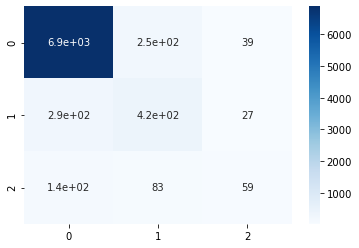

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# calculate confusion matrix
cm = confusion_matrix(act, pdt)

# extract TP, TN, FP, FN
TP = cm[1,1]
TN = cm[0,0]
FP = cm[0,1]
FN = cm[1,0]

# calculate PP and PN
PP = TP + FN
PN = TN + FP

# print results
print("True Positives (TP): ", TP)
print("True Negatives (TN): ", TN)
print("False Positives (FP): ", FP)
print("False Negatives (FN): ", FN)

# create heatmap using seaborn
sns.heatmap(cm, annot=True, cmap="Blues")

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# calculate precision, recall, and F1 score
precision = precision_score(act, pdt,average='weighted')
recall = recall_score(act, pdt,average='weighted')
f1 = f1_score(act, pdt,average='weighted')

# print results
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)
accuracy = (TP + TN) / (TP + TN + FP + FN)
print("Accuracy: ", accuracy)

Precision:  0.8906081050517051
Recall:  0.8988022488389147
F1 Score:  0.8928924990459948
Accuracy:  0.9310784939374601


#### BERT + xpos + classification

In [ ]:
act = []
pdt = []
for i in range(1500,2019):
    predict = predict_xpos(df1['Sentence'][i])
    actual = labels[i]
    for j in range(len(actual)):
        act.append(actual[j])
        pdt.append(predict[j])

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# calculate confusion matrix
cm = confusion_matrix(act, pdt)

# extract TP, TN, FP, FN
TP = cm[1,1]
TN = cm[0,0]
FP = cm[0,1]
FN = cm[1,0]

# calculate PP and PN
PP = TP + FN
PN = TN + FP

# print results
print("True Positives (TP): ", TP)
print("True Negatives (TN): ", TN)
print("False Positives (FP): ", FP)
print("False Negatives (FN): ", FN)

# create heatmap using seaborn
#sns.heatmap(cm, annot=True, cmap="Blues")



In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# calculate precision, recall, and F1 score
precision = precision_score(act, pdt,average='weighted')
recall = recall_score(act, pdt,average='weighted')
f1 = f1_score(act, pdt,average='weighted')

# print results
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)
accuracy = (TP + TN) / (TP + TN + FP + FN)
print("Accuracy: ", accuracy)

/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision:  0.8487448468685715
Recall:  0.8891469078464923
F1 Score:  0.8504153436270336
Accuracy:  0.9207695228452095


#### BERT + upos + classification 

In [ ]:
act = []
pdt = []
for i in range(1500,2019):
    predict = predict_xpos(df1['Sentence'][i])
    actual = labels[i]
    for j in range(len(actual)):
        act.append(actual[j])
        pdt.append(predict[j])

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# calculate confusion matrix
cm = confusion_matrix(act, pdt)

# extract TP, TN, FP, FN
TP = cm[1,1]
TN = cm[0,0]
FP = cm[0,1]
FN = cm[1,0]

# calculate PP and PN
PP = TP + FN
PN = TN + FP

# print results
print("True Positives (TP): ", TP)
print("True Negatives (TN): ", TN)
print("False Positives (FP): ", FP)
print("False Negatives (FN): ", FN)

# create heatmap using seaborn
# sns.heatmap(cm, annot=True, cmap="Blues")


True Positives (TP):  129
True Negatives (TN):  7146
False Positives (FP):  21
False Negatives (FN):  605


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# calculate precision, recall, and F1 score
precision = precision_score(act, pdt,average='weighted')
recall = recall_score(act, pdt,average='weighted')
f1 = f1_score(act, pdt,average='weighted')

# print results
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)
accuracy = (TP + TN) / (TP + TN + FP + FN)
print("Accuracy: ", accuracy)

/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision:  0.8487448468685715
Recall:  0.8891469078464923
F1 Score:  0.8504153436270336
Accuracy:  0.9207695228452095


**BERT Finetuning**

In [ ]:
tokenized_texts = [splitSentence(i) for i in df1['Sentence'][1500:].tolist()]
input_ids = [tokenizer.convert_tokens_to_ids(tokens) for tokens in tokenized_texts]
attention_masks = [[1] * len(tokens) for tokens in input_ids]
labels = list(df1['labels'][1500:])
model.eval()
with torch.no_grad():
    predicted = []
    count = 0 
    c = 0
    for i in range(len(input_ids)):
        outputs = model(torch.LongTensor(input_ids[i]).unsqueeze(0), attention_mask=torch.LongTensor(attention_masks[i]).unsqueeze(0))
        logits = outputs.logits
        preds = torch.argmax(logits, dim=2)
        count = count + len(preds[0])
        c = c + len(labels[i])
        predicted.extend(preds[0])
actual = []
for i in labels:
    actual.extend(i)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# calculate precision, recall, and F1 score
precision = precision_score(actual, predicted,average='weighted')
recall = recall_score(actual, predicted,average='weighted')
f1 = f1_score(actual, predicted,average='weighted')

# print results
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)

/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
 _warn_prf(average, modifier, msg_start, len(result))
Precision:  0.8921469078464923
Recall:  0.9187163686857155
F1 Score:  0.8804510619064015
